1. Read in HadEX TXx regression
2. Read in 20CR TXx regression
3. Regrid 20CR 
4. Run through comparison function

In [34]:
import xarray as xr
import numpy as np
import cf_xarray
import xesmf
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Open datasets and dataarrays 
obs_ds = xr.open_dataset('/g/data/w40/rl5183/HadEX3_TXx_regression.nc')
reanalysis_ds = xr.open_dataset('/g/data/w40/rl5183/20CR/temp/TXx_regression_all_members.nc')
obs_data = xr.open_dataarray('/g/data/w40/rl5183/HadEX3_TXx_regression.nc')
reanalysis_data = xr.open_dataarray('/g/data/w40/rl5183/20CR/temp/TXx_regression_all_members.nc')

In [3]:
# Calculate ensemble mean 
ensemble_mean = reanalysis_data.mean(dim='member')

In [4]:
# Set up regrid 
obs_bnds = obs_ds.cf.add_bounds(['latitude','longitude'])
reanalysis_bnds = reanalysis_ds.cf.add_bounds(['latitude','longitude'])

regrid = xesmf.Regridder(reanalysis_bnds, obs_bnds, method='conservative_normed')

In [5]:
# Regrid ensemble mean to match obs
ensemble_mean_regrid = regrid(ensemble_mean)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [30]:
# Rename dimensions
obs_data = obs_data.rename({'latitude': 'lat','longitude': 'lon'})
ensemble_mean_regrid = ensemble_mean_regrid.rename({'latitude': 'lat','longitude': 'lon'})
sample = obs_data.sel(month=11)

In [32]:
sign_comp_np = func.sign_corr(obs_data.sel(month=11), ensemble_mean_regrid.sel(month=11))
sign_comp_xr = xr.DataArray(sign_comp_np, coords=sample.coords, attrs=sample.attrs)

In [35]:
# Create colorbar 
cmap_sign = mpl.colors.ListedColormap(['red', 'blue', 'darkviolet', 'mediumpurple', 'lightgrey'])
bounds_sign = np.arange(-1,5)
norm_sign = mpl.colors.BoundaryNorm(bounds_sign+0.5, cmap_sign.N)

[Text(1, 0.0, 'Both Positive'),
 Text(1, 1.0, 'Both Negative'),
 Text(1, 2.0, 'HadEX3 Pos/20CR Neg'),
 Text(1, 3.0, 'HadEX3 Neg/20CR Pos'),
 Text(1, 4.0, 'NaN')]

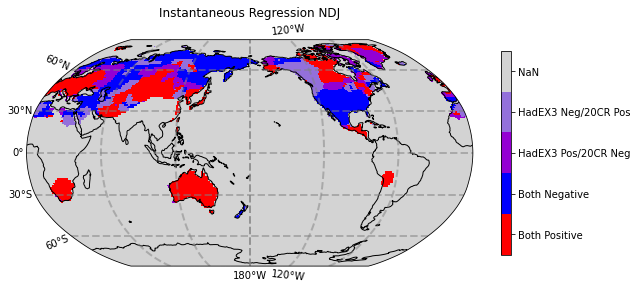

In [42]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111, projection=ccrs.Robinson(180))
C = sign_comp_xr.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_sign, norm=norm_sign, levels=bounds_sign+0.5)
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous Regression NDJ')

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Colorbar 
cbar = plt.colorbar(C, ax=ax, ticks=bounds_sign, shrink=0.75, pad=0.05)
cbar.ax.set_yticklabels(['Both Positive', 'Both Negative', 'HadEX3 Pos/20CR Neg', 'HadEX3 Neg/20CR Pos', 'NaN'])